# 📈 Nowcasting US GDP Growth during COVID-19 (Lab Activity)

**Objective**

+ Build a model to nowcast **U.S. quarterly GDP growth** using **monthly indicators** from the FRED-MD database. 
+ Focus on the period around COVID-19 (2020) to assess how well the models capture the economic shock in real-time.
+ The group that produces the **most accurate nowcasts (lowest RMSE)** will win.

---

## 📦 Data Overview

### High-Frequency Predictors

- **Source**: [FRED-MD](https://www.stlouisfed.org/research/economists/mccracken/fred-databases)
- **Frequency**: Monthly
- **Variables**: Over 100 U.S. macroeconomic series
- **Transformations**: First row of the dataset includes codes for applying transformations:
    - "1": No transformation
    - "2": First difference
    - "5": Log first difference, etc.
    - (You can use the `apply_transformation()` helper function if provided)

### Low-Frequency Target

- **Variable**: U.S. real GDP QoQ growth (quarterly growth rate in percent). Apply transformation (5) and multiply by 100.
- **Task**: Predict this variable using high-frequency monthly data (a mixed-frequency regression problem).

---

## 🎯 Forecasting Task

You must produce a **rolling nowcast**:
- **Alignment lag**: 0 (i.e., predict the current quarter using available monthly info)
- **Start rolling**: 2016-12-01
- **End rolling**: 2020-06-01

Your submission must be a **CSV file** with the following format:
```
date,target,prediction
2016-12-01,0.8,0.92
2017-03-01,1.2,0.59
...
2020-06-01,-4.3,-10.23
```
---

## 📤 Submission Instructions

- Export your final predictions to CSV:

```
df_nowcast = pd.DataFrame({
    "date": forecast_dates,         # datetime list or index
    "target": true_values,          # actual GDP growth
    "prediction": model_forecasts   # your nowcasts
})
df_nowcast.to_csv("group_name_nowcast.csv", index=False)
```
- Send this CSV file to renato.vassallo@bse.eu.

---

## 🧪 Evaluation

- Evaluation based on **RMSE** over the forecast horizon:
    - 2016-12-01 to 2020-06-01
- The team with the **lowest RMSE wins** 🎉

---

## ⏱️ Time Limit

⏰ 25 minutes
- Work in groups (up to 3 people)

---

## 💡 Ideas

- Select variables most correlated with GDP
- Normalize or lag variables
- Try dimensionality reduction

---

Good luck 🚀

## Helper functions

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def apply_transformation(series, code):
    """
    Apply FRED-MD transformation code to a pandas Series.
    """
    if code == "1":
        return series
    elif code == "2":
        return series.diff()
    elif code == "3":
        return series.diff().diff()
    elif code == "4":
        return np.log(series)
    elif code == "5":
        return np.log(series).diff()
    elif code == "6":
        return np.log(series).diff().diff()
    elif code == "7":
        return series.pct_change()
    else:
        return pd.Series(np.nan, index=series.index)
    
def keep_fully_populated_last_year(df, min_obs=12):
    """
    Keep only columns (series) with at least `min_obs` non-NaN values 
    in the last 12 months of the data.

    Args:
        df (pd.DataFrame): The time series DataFrame with datetime index
        min_obs (int): Minimum number of non-NaN observations required

    Returns:
        pd.DataFrame: Filtered DataFrame with only complete series
    """
    # Define the last 12 months in the index
    last_date = df.index.max()
    one_year_ago = last_date - pd.DateOffset(months=11)

    recent_data = df.loc[one_year_ago:last_date]
    print(f"Checking series completeness from {one_year_ago.date()} to {last_date.date()}")

    # Keep only columns with 12 valid values
    valid_series = [col for col in df.columns if recent_data[col].count() == min_obs]

    print(f"Keeping {len(valid_series)} of {df.shape[1]} series with full data in last 12 months.")

    return df[valid_series]

## Useful links

In [2]:
# Quarterly FRED-MD data URL (for target)
url_quart = "https://www.stlouisfed.org/-/media/project/frbstl/stlouisfed/research/fred-md/quarterly/current.csv"

y_df = pd.read_csv(url_quart)
y_df.columns.tolist()

# Monthly FRED-MD data URL (for features)
url_month = "https://www.stlouisfed.org/-/media/project/frbstl/stlouisfed/research/fred-md/monthly/current.csv"
x_df = pd.read_csv(url_month)

In [3]:
x_df_clean = x_df[1:].copy()
y_df_clean = y_df[2:].copy()
x_df_clean['date'] = pd.to_datetime(x_df_clean['sasdate'])
y_df_clean['date'] = pd.to_datetime(y_df_clean['sasdate'])

x_transform_codes = x_df.iloc[0].to_dict()
y_transform_codes = y_df.iloc[0].to_dict()

for key in x_transform_codes:
    if isinstance(x_transform_codes[key], (int, float)):
        x_transform_codes[key] = str(int(x_transform_codes[key]))
        
for key in y_transform_codes:
    if isinstance(y_transform_codes[key], (int, float)):
        y_transform_codes[key] = str(int(y_transform_codes[key]))

In [4]:
for col in x_df_clean.columns:
    if col not in ['sasdate', 'date']:  
        transform_code = x_transform_codes.get(col)  # default value is 1
        x_df_clean[col] = x_df_clean[col].astype(float)
        x_df_clean[col] = apply_transformation(x_df_clean[col], transform_code) # Uses the helper function to apply the corresponding transformation
        x_df_clean[col] = x_df_clean[col] * 100 # Multiply by 100 to make it a percentage variation.
        
print(x_df_clean.head())

    sasdate       RPI   W875RX1  DPCERA3M086SBEA  CMRMTSPLx   RETAILx  \
1  1/1/1959       NaN       NaN              NaN        NaN       NaN   
2  2/1/1959  0.387704  0.362081         1.034921   0.733599  0.730985   
3  3/1/1959  0.645660  0.732484         0.940436  -0.337374  0.832120   
4  4/1/1959  0.651034  0.702869        -0.362155   1.991538  0.061571   
5  5/1/1959  0.579642  0.661773         1.204252   0.683884  0.780339   

     INDPRO   IPFPNSS   IPFINAL   IPCONGD  ...  DSERRG3M086SBEA  \
1       NaN       NaN       NaN       NaN  ...              NaN   
2  1.939488  1.340455  0.862766  0.730907  ...              NaN   
3  1.429993  0.603599  0.489561  0.000000  ...         0.029242   
4  2.108010  1.433943  1.454466  1.565181  ...         0.175951   
5  1.495353  0.826659  0.958022  0.476612  ...        -0.186652   

   CES0600000008  CES2000000008  CES3000000008  UMCSENTx  DTCOLNVHFNM  \
1            NaN            NaN            NaN       NaN          NaN   
2           

In [5]:
y_df_clean['GDP'] = apply_transformation(y_df_clean['GDPC1'].astype(float), "5") # Apply the corresponding transformation to the target variable (GDP)
y_df_clean['GDP'] = y_df_clean['GDP'] * 100

In [6]:
merged_df = pd.merge(x_df_clean, y_df_clean[['date', 'GDP']], on='date', how='left')
start_filter_date = pd.Timestamp('1995-01-01') # Adding date filters for merge. Using timestamp instead of datetime because is more efficient for single values.
end_filter_date = pd.Timestamp('2020-06-01')

merged_df = merged_df[(merged_df['date'] >= start_filter_date) & 
                         (merged_df['date'] <= end_filter_date)]

Top 5 var
M1SL             0.687025
CES3000000008    0.487541
M2SL             0.467098
CES0600000008    0.427763
dtype: float64


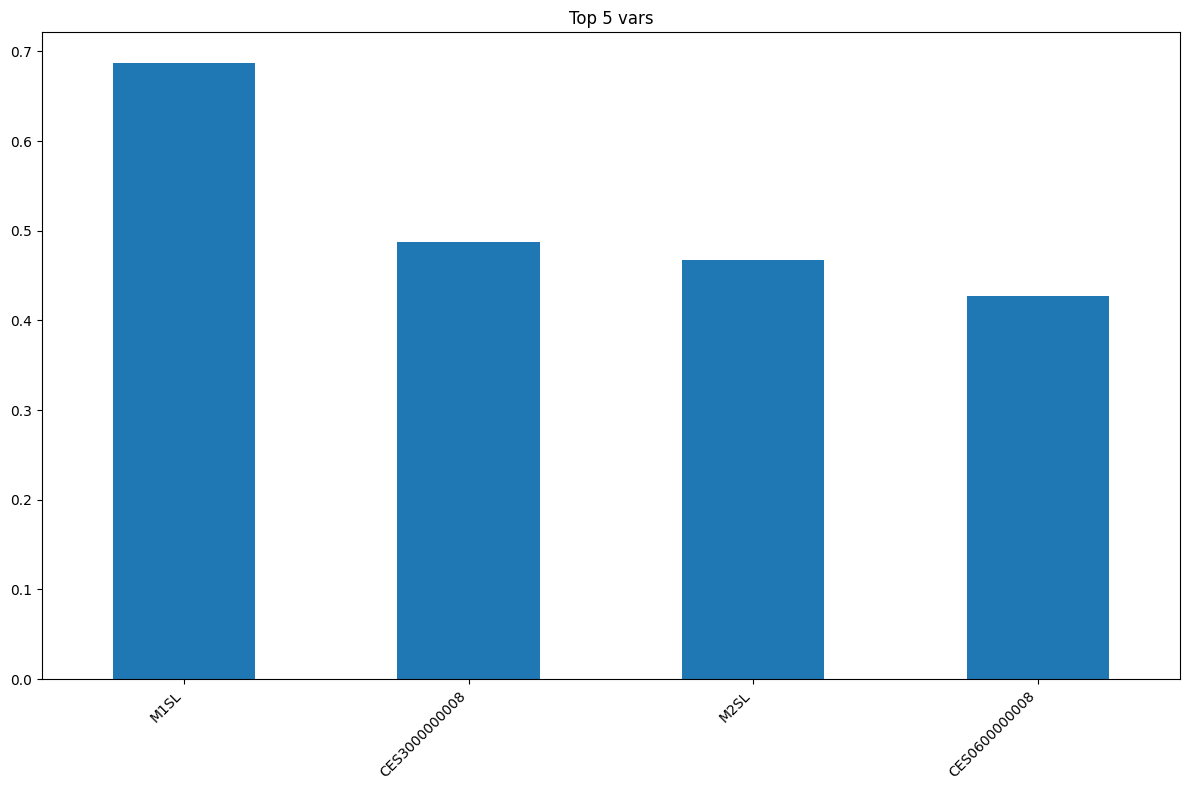

In [7]:
start_filter_date = pd.Timestamp('2016-12-01') # Filtering dates for training.
end_filter_date = pd.Timestamp('2020-06-01')

cropped_df = merged_df[(merged_df['date'] >= start_filter_date) & 
                         (merged_df['date'] <= end_filter_date)]

numeric_df = cropped_df.select_dtypes(include=['number']).drop(columns=['sasdate', 'date'], errors='ignore')
numeric_df = numeric_df.fillna(0)


correlations = numeric_df.corrwith(numeric_df['GDP']).sort_values(ascending=False)
top_5_corr = correlations.iloc[1:5] # Exclude GDP itself from the top 5 (Starting index at 1)
print("Top 5 var")
print(top_5_corr)

plt.figure(figsize=(12, 8))
top_5_corr.plot(kind='bar')
plt.title('Top 5 vars')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [8]:
#!pip show midas
from MIDAS import MIDAS

In [9]:
filtered_df_indexed = merged_df.copy().set_index('date')

midas_model = MIDAS(low_freq_series       = filtered_df_indexed["GDP"],
                    high_freq_series_list = [filtered_df_indexed['M1SL']],
                    hf_lags_list          = ["3m"], # Includes the last 3 months of the high frequency series (Because Low frequency series is quarterly, we use 3 months of high frequency data)
                    lf_lags               = 1) # Why 1 lag, is it because we are nowcasting? Or is beca

In [10]:
from datetime import datetime

# Prepare the data (optional, just to inspect the structure)
result = midas_model.prepare_data(alignment_lag = 0, # Lag of 0 to do nowcasting.
                                  start_date    = datetime(1995, 3, 1), # training start date.
                                  end_date      = datetime(2016, 12, 1)) # training end date.

# Display results
print("Y Data (Training):\n",    result["y_train"].head())
print("\nY Lags (Training):\n",  result["y_train_lags"].head())
print("\nHF Data (Training):\n", result["x_train_list"][0].head())
print("\nY Data (Test):\n",      result["y_forecast_target"].head())
print("\nY Lags (Test):\n",      result["y_forecast_lags"].head())
print("\nHF Data (Test):\n",     result["x_forecast_list"][0].head())

Y Data (Training):
 date
1995-06-01    0.297879
1995-09-01    0.847127
1995-12-01    0.676787
1996-03-01    0.746259
1996-06-01    1.654187
Name: GDP, dtype: float64

Y Lags (Training):
                  GDP
date                
1995-06-01  0.354153
1995-09-01  0.297879
1995-12-01  0.847127
1996-03-01  0.676787
1996-06-01  0.746259

HF Data (Training):
                    0         1         2
date                                    
1995-06-01  0.252554 -0.575126  0.287507
1995-09-01 -0.288551 -0.122282  0.209643
1995-12-01 -0.301895  0.130643 -0.115127
1996-03-01  0.811923 -0.090633  0.228261
1996-06-01  0.624142 -0.936427 -0.170110

Y Data (Test):
 date
2016-12-01    0.552769
2017-03-01    0.485709
2017-06-01    0.558311
2017-09-01    0.785432
2017-12-01    1.120743
Name: GDP, dtype: float64

Y Lags (Test):
                  GDP
date                
2016-12-01  0.706886
2017-03-01  0.552769
2017-06-01  0.485709
2017-09-01  0.558311
2017-12-01  0.785432

HF Data (Test):
             

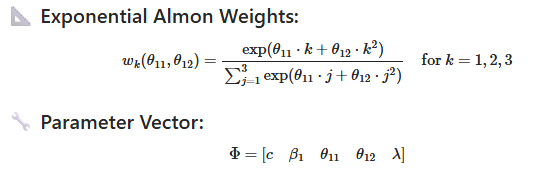

In [11]:
# Fit the model
opt_res = midas_model.fit(data_dict = result, 
						 poly_list=["expalmon"])

# Extract fitted parameters
opt_res.x # Almnon Parameter vector

array([ 0.45687779, -0.41582315,  2.88941993, -0.97522741,  0.32964485])

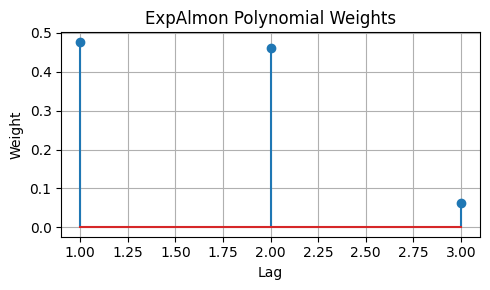

In [12]:
from MIDAS import ExpAlmonWeights

expalmon = ExpAlmonWeights()
theta_exp_almon = opt_res.x[2:4]  # assuming [theta1, theta2] are at positions 2 and 3
expalmon.theta = theta_exp_almon
nlags = 3  
weights = expalmon.weights(nlags)

# Plot
plt.figure(figsize=(5, 3))
plt.stem(range(1, nlags + 1), weights)
plt.title('ExpAlmon Polynomial Weights')
plt.xlabel('Lag')
plt.ylabel('Weight')
plt.grid(True)
plt.tight_layout()
plt.show()

In [13]:
# Nowcast the low-frequency series
pred = midas_model.predict(data_dict = result)

# Join predictions
y_target_df = result["y_forecast_target"].to_frame(name="y_target") # Extract the y_forecast_target from the result dictionary and create a DataFrame with a single column named 'y_target'
forecast_df = y_target_df.join(pred)
forecast_df.columns = ['y_target', 'y_nowcast']
forecast_df

,y_target,y_nowcast
date,,
2016-12-01,0.552769,0.771663
2017-03-01,0.485709,0.637626
2017-06-01,0.558311,0.615314
2017-09-01,0.785432,0.851806
2017-12-01,1.120743,0.943091
2018-03-01,0.810119,0.772361
2018-06-01,0.529421,0.739117
2018-09-01,0.621760,0.693360
2018-12-01,0.141544,0.449259


In [14]:
df_rolling, rmse = midas_model.rolling_forecast(start_date = datetime(1995, 3, 1),
                                                end_date   = datetime(2016, 12, 1),
                                                alignment_lag = 0,
                                                poly_list = ["expalmon"],
                                                verbose = True)
df_rolling

Rolling window end = 2016-12-01 00:00:00 | Forecast horizon = 0
Rolling window end = 2017-03-01 00:00:00 | Forecast horizon = 0
Rolling window end = 2017-06-01 00:00:00 | Forecast horizon = 0
Rolling window end = 2017-09-01 00:00:00 | Forecast horizon = 0
Rolling window end = 2017-12-01 00:00:00 | Forecast horizon = 0
Rolling window end = 2018-03-01 00:00:00 | Forecast horizon = 0
Rolling window end = 2018-06-01 00:00:00 | Forecast horizon = 0
Rolling window end = 2018-09-01 00:00:00 | Forecast horizon = 0
Rolling window end = 2018-12-01 00:00:00 | Forecast horizon = 0
Rolling window end = 2019-03-01 00:00:00 | Forecast horizon = 0
Rolling window end = 2019-06-01 00:00:00 | Forecast horizon = 0
Rolling window end = 2019-09-01 00:00:00 | Forecast horizon = 0
Rolling window end = 2019-12-01 00:00:00 | Forecast horizon = 0
Rolling window end = 2020-03-01 00:00:00 | Forecast horizon = 0
Rolling window end = 2020-06-01 00:00:00 | Forecast horizon = 0

✅ Final RMSE: 0.2530


,preds,targets
2016-12-01,0.771663,0.552769
2017-03-01,0.631328,0.485709
2017-06-01,0.614859,0.558311
2017-09-01,0.846833,0.785432
2017-12-01,0.943489,1.120743
2018-03-01,0.774274,0.810119
2018-06-01,0.731985,0.529421
2018-09-01,0.690850,0.621760
2018-12-01,0.434102,0.141544
2019-03-01,0.639475,0.622377


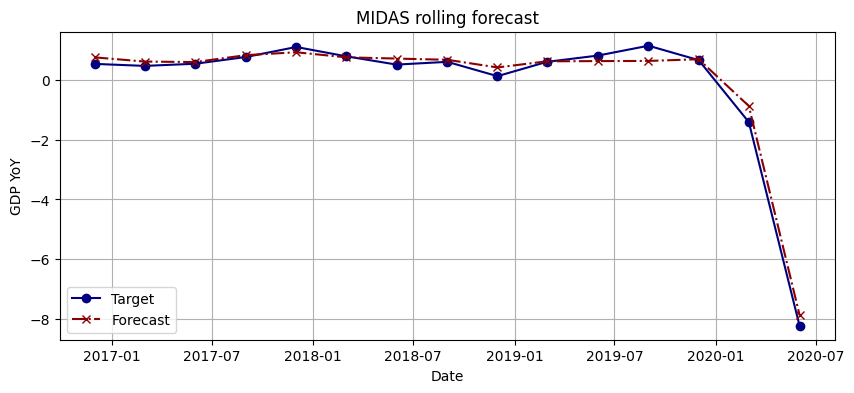

In [15]:
# Plot the predictions
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
plt.plot(df_rolling.index, df_rolling["targets"], label="Target", color='navy', marker='o')
plt.plot(df_rolling.index, df_rolling["preds"], label="Forecast", color='darkred', marker='x', linestyle='-.')
plt.title("MIDAS rolling forecast")
plt.xlabel("Date")
plt.ylabel("GDP YoY")
plt.legend()
plt.grid()
plt.show()

In [16]:
mod1 = MIDAS(low_freq_series       = filtered_df_indexed["GDP"],
             high_freq_series_list = [filtered_df_indexed["M1SL"]],
             hf_lags_list          = ["3m"], 
             lf_lags               = 1)

df1, rmse1 = mod1.rolling_forecast(start_date = datetime(1995, 3, 1),
                                   end_date   = datetime(2016, 12, 1),
                                   alignment_lag = 0,
                                   poly_list = ["expalmon"],
                                   verbose = False)

print("RMSE for the first model:", rmse1)

RMSE for the first model: 0.2529652754662826


In [17]:
mod2 = MIDAS(low_freq_series       = filtered_df_indexed["GDP"],
             high_freq_series_list = [filtered_df_indexed["M1SL"], filtered_df_indexed["CES3000000008"]],
             hf_lags_list          = ["3m", "3m"], 
             lf_lags               = 1)

df2, rmse2 = mod2.rolling_forecast(start_date = datetime(1995, 3, 1),
                                   end_date   = datetime(2016, 12, 1),
                                   alignment_lag = 0,
                                   poly_list = ["expalmon", "expalmon"],
                                   verbose = False)
print("RMSE for the second model:", rmse2)

RMSE for the second model: 0.24510504233976507


In [18]:
mod3 = MIDAS(low_freq_series       = filtered_df_indexed["GDP"],
             high_freq_series_list = [filtered_df_indexed["M1SL"], filtered_df_indexed["M2SL"]],
             hf_lags_list          = ["3m", "3m"], 
             lf_lags               = 1)

df3, rmse3 = mod3.rolling_forecast(start_date = datetime(1995, 3, 1),
                                   end_date   = datetime(2016, 12, 1),
                                   alignment_lag = 0,
                                   poly_list = ["expalmon", "expalmon"],
                                   verbose = False)
print("RMSE for the third model:", rmse3)

RMSE for the third model: 0.19752280062615876


In [19]:
mod4 = MIDAS(low_freq_series       = filtered_df_indexed["GDP"],
             high_freq_series_list =[filtered_df_indexed["M1SL"], filtered_df_indexed["CES3000000008"], filtered_df_indexed["M2SL"]] ,
             hf_lags_list          = ["3m", "3m", "3m"], 
             lf_lags               = 1)
df4, rmse4 = mod4.rolling_forecast(start_date = datetime(1995, 3, 1),
                                   end_date   = datetime(2016, 12, 1),
                                   alignment_lag = 0,
                                   poly_list = ["expalmon", "expalmon", "expalmon"],
                                   verbose = False)
print("RMSE for the fourth model:", rmse4)

RMSE for the fourth model: 0.20159158489538517


Model using PCA:

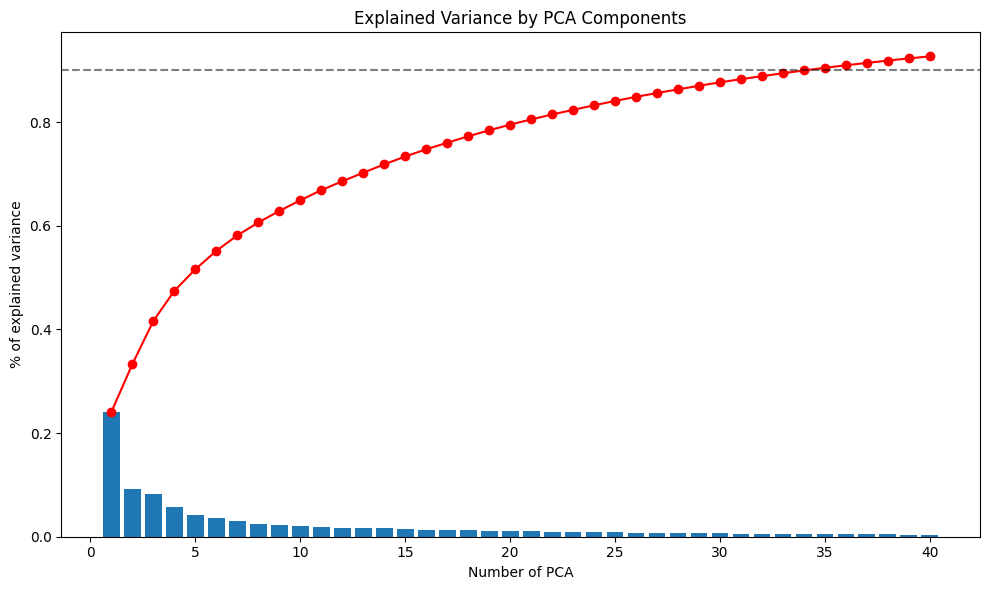

Rolling window end = 2016-12-01 00:00:00 | Forecast horizon = 0
Rolling window end = 2017-03-01 00:00:00 | Forecast horizon = 0
Rolling window end = 2017-06-01 00:00:00 | Forecast horizon = 0
Rolling window end = 2017-09-01 00:00:00 | Forecast horizon = 0
Rolling window end = 2017-12-01 00:00:00 | Forecast horizon = 0
Rolling window end = 2018-03-01 00:00:00 | Forecast horizon = 0
Rolling window end = 2018-06-01 00:00:00 | Forecast horizon = 0
Rolling window end = 2018-09-01 00:00:00 | Forecast horizon = 0
Rolling window end = 2018-12-01 00:00:00 | Forecast horizon = 0
Rolling window end = 2019-03-01 00:00:00 | Forecast horizon = 0
Rolling window end = 2019-06-01 00:00:00 | Forecast horizon = 0
Rolling window end = 2019-09-01 00:00:00 | Forecast horizon = 0
Rolling window end = 2019-12-01 00:00:00 | Forecast horizon = 0
Rolling window end = 2020-03-01 00:00:00 | Forecast horizon = 0
Rolling window end = 2020-06-01 00:00:00 | Forecast horizon = 0

✅ Final RMSE: 0.0762
RMSE with PCA mode

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

pca_indicators = filtered_df_indexed.copy().drop(columns=['GDP', 'sasdate', 'date'], errors='ignore')
pca_indicators = pca_indicators.fillna(0)  # Fill NaN values with 0 for PCA

# Scaling for PCA
scaler = StandardScaler()
scaled_data = scaler.fit_transform(pca_indicators)

n_components = 40 # If the number of components is set too low like 10 the performance will be worst than the model 3.
pca = PCA(n_components=n_components)
principal_components = pca.fit_transform(scaled_data)

explained_variance = pca.explained_variance_ratio_
cumulative_variance = explained_variance.cumsum()

# Explained variance plot
plt.figure(figsize=(10, 6))
plt.bar(range(1, n_components+1), explained_variance)
plt.plot(range(1, n_components+1), cumulative_variance, 'r-o')
plt.xlabel('Number of PCA')
plt.ylabel('% of explained variance')
plt.title('Explained Variance by PCA Components')
plt.axhline(y=0.9, color='k', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Transform to DataFrame and then series to use in MIDAS
pc_df = pd.DataFrame(principal_components, index=pca_indicators.index)
pc_series_list = [pc_df[i] for i in range(n_components)]

# Set up the MIDAS model with PCA components
pc_lags_list = ["3m"] * n_components
pc_poly_list = ["expalmon"] * n_components

mod_pca = MIDAS(low_freq_series = filtered_df_indexed["GDP"],
                high_freq_series_list = pc_series_list,
                hf_lags_list = pc_lags_list,
                lf_lags = 1)


df_pca, rmse_pca = mod_pca.rolling_forecast(
                               start_date = datetime(1995, 3, 1),
                               end_date = datetime(2016, 12, 1),
                               alignment_lag = 0,
                               poly_list = pc_poly_list,
                               verbose = True)

print(f"RMSE with PCA model (40 Components): {rmse_pca}")

Reduccing the dimensionality to 40 we are able to explain almos all the variability in GDP

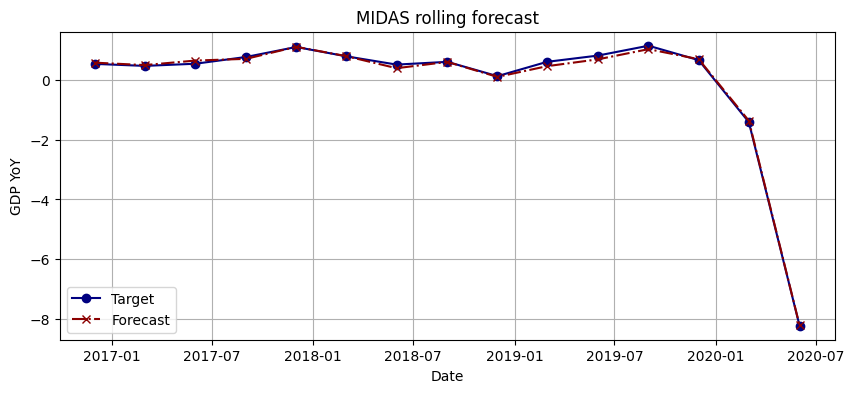

In [21]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
plt.plot(df_pca.index, df_pca["targets"], label="Target", color='navy', marker='o')
plt.plot(df_pca.index, df_pca["preds"], label="Forecast", color='darkred', marker='x', linestyle='-.')
plt.title("MIDAS rolling forecast")
plt.xlabel("Date")
plt.ylabel("GDP YoY")
plt.legend()
plt.grid()
plt.show()

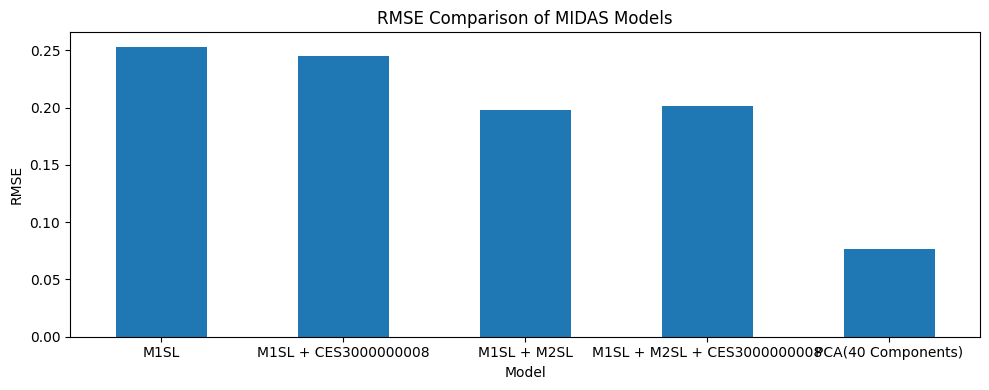

,RMSE
Model,
M1SL,0.252965
M1SL + CES3000000008,0.245105
M1SL + M2SL,0.197523
M1SL + M2SL + CES3000000008,0.201592
PCA(40 Components),0.076241


In [22]:
# Compare RMSE values
rmse_df = pd.DataFrame({
    'Model': ['M1SL', 'M1SL + CES3000000008', 'M1SL + M2SL', 'M1SL + M2SL + CES3000000008', 'PCA(40 Components)'],
    'RMSE': [rmse1, rmse2, rmse3, rmse4, rmse_pca]
})
rmse_df.set_index('Model', inplace=True)
rmse_df.plot(kind='bar', figsize=(10, 4), legend=False)
plt.title('RMSE Comparison of MIDAS Models')
plt.ylabel('RMSE')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

rmse_df

Fitting model: M1SL
Fitting model: M1SL + CES3000000008
Fitting model: M1SL + M2SL
Fitting model: M1SL + CES3000000008 + M2SL


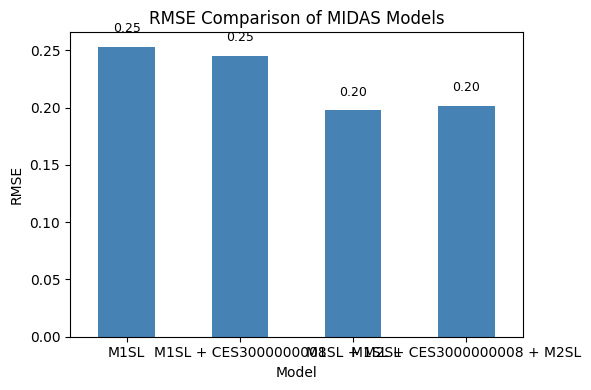

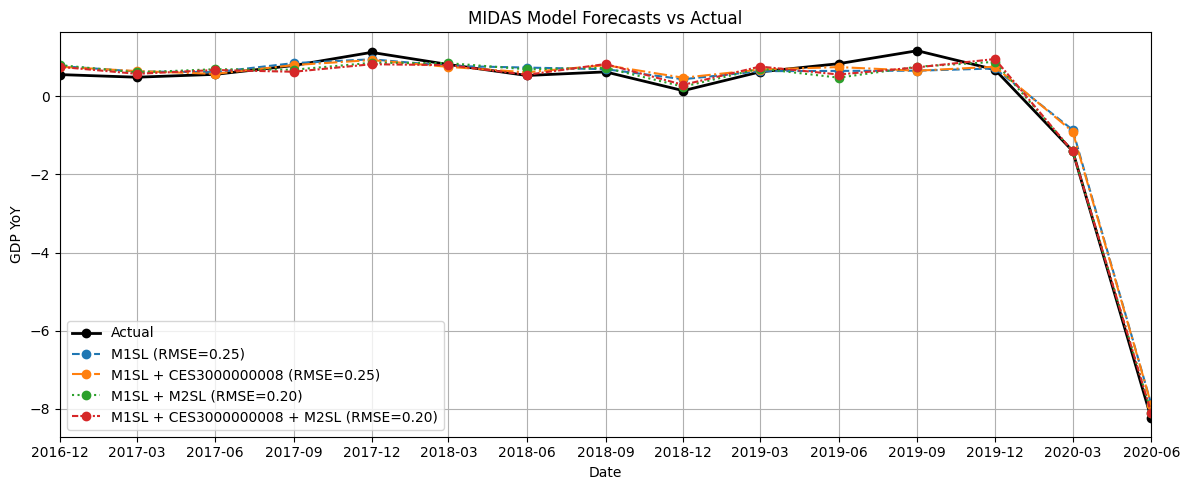

In [23]:
from MIDAS import midas_compare

models = [
    {"name": "M1SL", "high_freq_series": [filtered_df_indexed["M1SL"]], "polys": ["expalmon"]},
    {"name": "M1SL + CES3000000008", "high_freq_series": [filtered_df_indexed["M1SL"], filtered_df_indexed["CES3000000008"]], "polys": ["expalmon", "expalmon"]},
    {"name": "M1SL + M2SL", "high_freq_series": [filtered_df_indexed["M1SL"], filtered_df_indexed["M2SL"]], "polys": ["expalmon", "expalmon"]},
    {"name": "M1SL + CES3000000008 + M2SL", "high_freq_series": [filtered_df_indexed["M1SL"], filtered_df_indexed["M2SL"], filtered_df_indexed["CES3000000008"]], "polys": ["expalmon", "expalmon", "expalmon"]},
]

results = midas_compare(
    low_freq_series=filtered_df_indexed["GDP"],
    model_specs=models,
    hf_lags=["3m", "3m", "3m"], 
    lf_lags=1,
    alignment_lag=0,
    start_date=datetime(1995, 3, 1),
    end_date=datetime(2016, 12, 1),
    plot_forecasts=True
)

In [24]:
submission_df = pd.DataFrame({
    "date": df3.index,
    "target": df3["targets"],
    "prediction": df3["preds"]
})

print(submission_df)
print("=" * 50)
print(f"Final RMSE: {rmse3}")


submission_df.to_csv("HW2_forecasting_submission.csv", index=False)

                 date    target  prediction
2016-12-01 2016-12-01  0.552769    0.795014
2017-03-01 2017-03-01  0.485709    0.607504
2017-06-01 2017-06-01  0.558311    0.690140
2017-09-01 2017-09-01  0.785432    0.677444
2017-12-01 2017-12-01  1.120743    0.854013
2018-03-01 2018-03-01  0.810119    0.845277
2018-06-01 2018-06-01  0.529421    0.688193
2018-09-01 2018-09-01  0.621760    0.724830
2018-12-01 2018-12-01  0.141544    0.244188
2019-03-01 2019-03-01  0.622377    0.706555
2019-06-01 2019-06-01  0.831678    0.474065
2019-09-01 2019-09-01  1.163210    0.754430
2019-12-01 2019-12-01  0.679564    0.878557
2020-03-01 2020-03-01 -1.402226   -1.405153
2020-06-01 2020-06-01 -8.239259   -8.090121
Final RMSE: 0.19752280062615876


In [25]:
submission_pca_df = pd.DataFrame({
    "date": df_pca.index,
    "target": df_pca["targets"],
    "prediction": df_pca["preds"]
})

print(submission_pca_df)
print("=" * 50)
print(f"Final RMSE: {rmse_pca}")

submission_pca_df.to_csv("HW2_forecasting_submission.csv", index=False)

                 date    target  prediction
2016-12-01 2016-12-01  0.552769    0.594001
2017-03-01 2017-03-01  0.485709    0.512792
2017-06-01 2017-06-01  0.558311    0.664621
2017-09-01 2017-09-01  0.785432    0.722697
2017-12-01 2017-12-01  1.120743    1.126444
2018-03-01 2018-03-01  0.810119    0.816193
2018-06-01 2018-06-01  0.529421    0.408172
2018-09-01 2018-09-01  0.621760    0.619033
2018-12-01 2018-12-01  0.141544    0.116391
2019-03-01 2019-03-01  0.622377    0.476603
2019-06-01 2019-06-01  0.831678    0.704819
2019-09-01 2019-09-01  1.163210    1.047916
2019-12-01 2019-12-01  0.679564    0.710884
2020-03-01 2020-03-01 -1.402226   -1.354020
2020-06-01 2020-06-01 -8.239259   -8.226319
Final RMSE: 0.07624109102134585
